# TimeEvolvingMPO - Tutorial

The TimeEvolvingMPO library is currently under construction. This example serves merely as a placeholder for the tutorial to come. However, you can check that you can access the (almost) empty library by executing the `Say hi!` example below.

-------------------------------------------------
## Say hi!
This is just to check that you can access the tempo package.

In [1]:
import time_evolving_mpo as tempo

In [2]:
tempo.say_hi()


Hi there!
This is TimeEvolvingMPO version 0.0.1-2 speaking!



-------------------------------------------------
## Example A - The Minimal Example
ToDo: Explain what we do here

Import what we need:

In [3]:
import time_evolving_mpo as tempo
import numpy as np
import matplotlib.pyplot as plt

### The Bath

Define the physics of the bath:

In [4]:
# the coupling to the spin is the sigma z operator. 
coupling_operator = tempo.operators.pauli("z") 

# spectral density with J(w) = 2 * alpha * w**zeta * cutoff**(1-zeta) * exp(-w/cutoff)
spectral_density = tempo.StandardSD(alpha=0.3, zeta=1.0, cutoff=4.0)

# temperature of the bath
temperature = 0.1

Create a `tempo.Bath` object to encapsulate this bath information:

In [5]:
bath_A = tempo.Bath(coupling_operator, spectral_density, temperature=temperature)

### The System

Define the system Hamiltonian:

In [6]:
epsilon = 1.0
Delta = 0.1
hamiltonian = epsilon/2.0 * tempo.operators.pauli("z") \
              + Delta/2.0 * tempo.operators.pauli("x")

Create a `tempo.System` object to encapsulate this system information:

In [7]:
system_A = tempo.System(hamiltonian)

### The Computation

Define the initial state as well as the start and end time:

In [8]:
initial_state = np.array([[1.0,0.0],[0.0,0.0]]) # start in the up-state
t_start_A = 0.0
t_end_A = 10.0

Create a `tempo.Tempo` object:

In [9]:
tempo_A = tempo.Tempo(bath_A, system_A , initial_state, t_start_A, t_end_A)

Make the actual computation:

In [10]:
tempo_A.compute()

Get a `tempo.Dynamics` object from `tempo_A`:

In [11]:
dynamics_A = tempo_A.get_dynamics()

Get expectation values for a specific operator:

In [12]:
sigma_z = np.array([[1.0,0.0],[0.0,-1.0]]) 
t_A, y_A = dynamics_A.get_expectations(sigma_z, real=True)

In [13]:
# cheat because the whole thing is not yet implemented
if t_A is NotImplemented or y_A is NotImplemented:
    t_A, y_A = np.array([0.0,0.1,0.2,0.3]), np.array([1.0,0.99,0.90,0.70]) 

Plot the results:

Text(0, 0.5, '$<\\sigma_z>$')

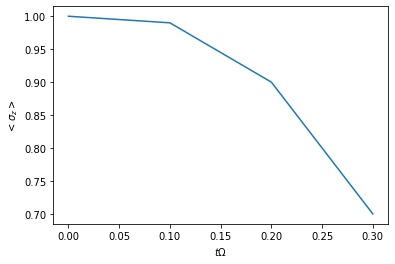

In [14]:
plt.plot(t_A, y_A)    
plt.xlabel(r'$t \Omega$')
plt.ylabel(r'$<\sigma_z>$')